TESSERACT

In [152]:
import cv2
import numpy as np
import pytesseract
from pytesseract import Output
import re
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm

#в vscode не работает: import src.features.build_features as pp


def rotate(image, center = None, scale = 1.0):
    angle=360-int(re.search('(?<=Rotate: )\d+', pytesseract.image_to_osd(image)).group(0))
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated


def crop_and_gray(img_path):

    img = cv2.imdecode(np.fromfile(img_path, dtype=np.int32), 1)

    #crop part
    h, w = img.shape[:2]
    if w >= h:
        img = img[0:h,0:int(w/(1.1*(w/h)))]
    else:
        img = img[0:int(h/(1.1*(h/w))), 0:w]

    #grayscale part
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return rotate(gray)


def get_predictions(prepared_image):
    """
    Желательно подавать готовое изображение (обрезанное и черно-белое)
    """
    d = pytesseract.image_to_data(prepared_image, output_type=Output.DICT, lang='rus')

    rgb = cv2.cvtColor(prepared_image, cv2.COLOR_GRAY2RGB)
    # print(d.keys())

    bboxes = []
    texts = []
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) >= 0 and len(set(d['text'][i]))>1:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            bboxes.append([x, y, x + w, y + h])
            texts.append(d['text'][i])
            rgb = cv2.rectangle(rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return rgb, bboxes, texts

['Заказа:', '—_@9БВ.', 'РЫРГИС-5—|', 'Скг.', '224908', '«<.', 'Ерсибайкинакая.', 'Дат:', '7.0.89:.', 'со', 'МАЗМОМЕ.', '{2', 'очи.', 'не', 'би', 'Пр:', 'Козенкоба.', 'Кабернотер', '-3', '-2.', '«208']
21


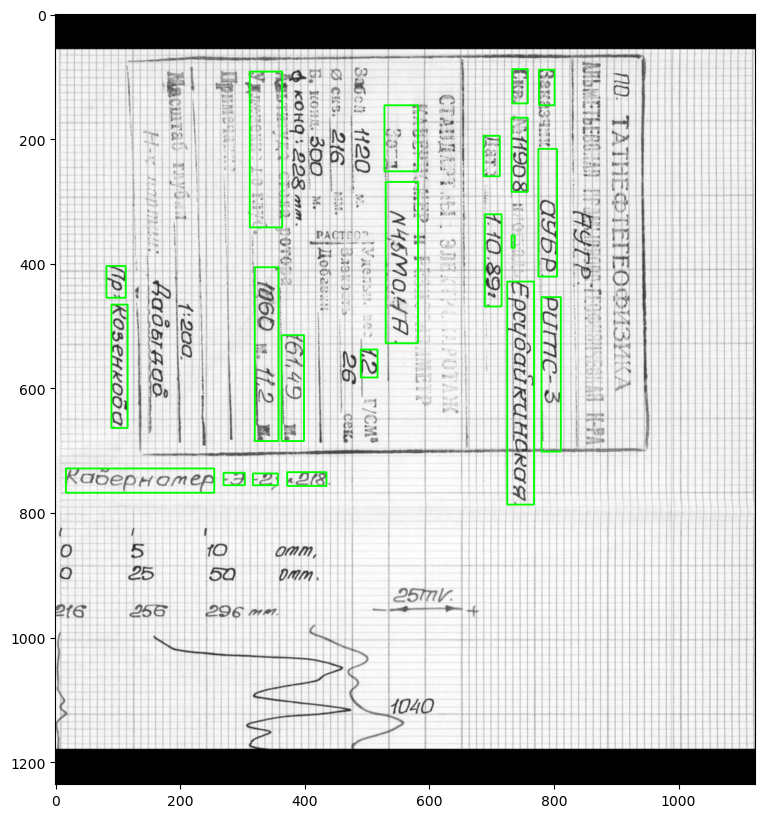

In [153]:
img_path = r"C:\Users\Nigel\Desktop\tatneft\test10.jpg"

rotated = crop_and_gray(img_path)
image, bboxes, texts = get_predictions(rotated)


#СОЗДАТЬ txt файлы с ббоксами и лейблами-----
# with open('bboxes.txt', 'w') as f:
#     for bbox in bboxes:
#         f.write('\t'.join(map(str, bbox))+'\n')

# with open('texts.txt', 'w') as f:
#     for label in texts:
#         f.write(label+ '\n')

# cv2.imwrite("inference1.jpg", image)

#Вывод на экран
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(image)

print(texts)
print(len(texts))

In [84]:
####ПАРСИНГ ФОРМАТА MMOCR В ФОРМАТ TESSERACT

# import shutil
# import os

# old_dir = r"C:\Users\Nigel\Desktop\tatneft\tatneft_dataset"
# new_dir = r"C:\Users\Nigel\Desktop\tatneft\tatneft_dataset_update"
# new_dir_labels = os.path.join(new_dir, "labels")

# with open(r"C:\Users\Nigel\Desktop\tatneft\tatneft_dataset\labels\train.txt", "r") as f:
#     lines = f.readlines()
#     for line  in lines:
#         content = line.split()
#         file = content[0]
#         label = ' '.join(content[1:])

#         txt_file = file[:-4] + ".gt.txt"
#         shutil.copy(os.path.join(old_dir, file), os.path.join(new_dir, file))
#         with open(os.path.join(new_dir_labels, txt_file), "w") as lab:
#             lab.write(label)

In [ ]:
###ГЕНЕРАЦИЯ ПРЕДИКТОВ В ФОРМАТЕ MMOCR

DATASET_PATH = r"C:\Users\Nigel\Desktop\tatneft\tatneft_2"
files = glob.glob(os.path.join(DATASET_PATH,"*.jpg"))#ALL FILES!!!

for doc_num, file in enumerate(tqdm(files)):
    doc_num += 6 #Начианем с 6 т.к уже есть 6 доков

    rotated = crop_and_gray(file)
    image, bboxes, texts = get_predictions(rotated)
    h, w = image.shape[:2]

    for file_num, (polygon, word) in enumerate(zip(bboxes, texts)):

        curr_pol = []#FIX polygone
        for k, v in enumerate(polygon):
            if k % 2 == 0:
                curr_pol.append(np.min([v,w]))
            else:
                curr_pol.append(np.min([v,h]))
                
        new_curr_pol = [min(polygon[1],polygon[3]), max(polygon[1],polygon[3]), min(polygon[0], polygon[2]), max(polygon[0], polygon[2])]
        cropped_image = image[new_curr_pol[0]-5:new_curr_pol[1]+5, new_curr_pol[2]-5:new_curr_pol[3]+5]

        if cropped_image.shape[0]!=0 and cropped_image.shape[1]!=0:
            cv2.imwrite(f'C:/Users/Nigel/Desktop/tatneft/tatneft_dataset2/{doc_num}_{file_num}.jpg', cropped_image)

            with open(os.path.join(DATASET_PATH, "C:/Users/Nigel/Desktop/tatneft/tatneft_dataset2/labels/labels.txt"), "a") as f_labels:
                f_labels.write(f"{doc_num}_{file_num}.jpg\t{word}\n")